In [1]:
# Libraries

import numpy
import os
import shutil

In [2]:
# Code

from src.data.feature import annodata as data_anndata
from src.data.feature import target   as data_target
from src.io           import loader   as data_loader
from src.io           import writer   as data_writer

# 1. Setup

In [3]:
# Setup some directory paths

OUT_SUBFOLDER = 'nbp05-target'
RES_SUBFOLDER = ''

CWD = os.getcwd()
OUT = os.path.join(CWD, 'out')
RES = os.path.join(CWD, 'res')

OUT_DATA  = os.path.join(OUT, 'data',  OUT_SUBFOLDER)
OUT_PLOT  = os.path.join(OUT, 'plot',  OUT_SUBFOLDER)
RES_PLANT = os.path.join(RES, 'plant', RES_SUBFOLDER)
RES_NBP02 = os.path.join(OUT, 'data',  'nbp02-anndata')

shutil.rmtree(OUT_DATA, ignore_errors = True)
shutil.rmtree(OUT_PLOT, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT}')
print(f' Resource Directory : {RES}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\res


In [4]:
# Load the annotated and cleaned data

anndata = data_loader.load_h5ad(
	filename = os.path.join(RES_NBP02, 'arabidopsis-r36.h5ad')
)

# 2. TPM Regression

In [5]:
# Extract the gene tpm values

values, order = data_target.extract_tpm_multi(
	data      = anndata,
	layer     = 'normal',
	groups    = ['Tissue', 'Age', 'Group', 'Perturbation'],
	functions = [
		('max',  lambda x : numpy.max(x, axis = 0)),
		('p80',  lambda x : numpy.percentile(x, 80, axis = 0)),
		('mean', lambda x : numpy.mean(x, axis = 0)),
		('std',  lambda x : numpy.std(x, axis = 0))
	]
)

In [6]:
# Display an example of the gene tpm values

gene = anndata.var.index.to_list()[0]

for index, (key, value) in enumerate(values[gene].items()) :
	print(f'{key:17s} : [{len(value):2d}] ' + ' '.join('{:5.3f}'.format(x) for x in value))

tissue-max        : [ 8] 0.472 0.575 0.465 0.600 0.547 0.584 0.547 0.245
tissue-p80        : [ 8] 0.382 0.370 0.374 0.506 0.364 0.430 0.448 0.151
tissue-mean       : [ 8] 0.342 0.290 0.265 0.458 0.326 0.367 0.321 0.096
tissue-std        : [ 8] 0.047 0.099 0.127 0.074 0.073 0.077 0.179 0.076
age-max           : [ 5] 0.579 0.575 0.398 0.547 0.600
age-p80           : [ 5] 0.420 0.451 0.355 0.432 0.482
age-mean          : [ 5] 0.330 0.364 0.316 0.238 0.404
age-std           : [ 5] 0.104 0.085 0.042 0.185 0.083
group-max         : [19] 0.472 0.562 0.465 0.578 0.348 0.579 0.361 0.575 0.469 0.385 0.398 0.547 0.245 0.382 0.430 0.279 0.600 0.547 0.584
group-p80         : [19] 0.396 0.358 0.374 0.509 0.328 0.419 0.341 0.462 0.451 0.365 0.355 0.448 0.151 0.379 0.379 0.277 0.507 0.479 0.453
group-mean        : [19] 0.346 0.282 0.264 0.463 0.287 0.360 0.323 0.382 0.370 0.297 0.316 0.321 0.096 0.375 0.357 0.274 0.459 0.413 0.381
group-std         : [19] 0.052 0.096 0.133 0.078 0.059 0.074 0.019 0.08

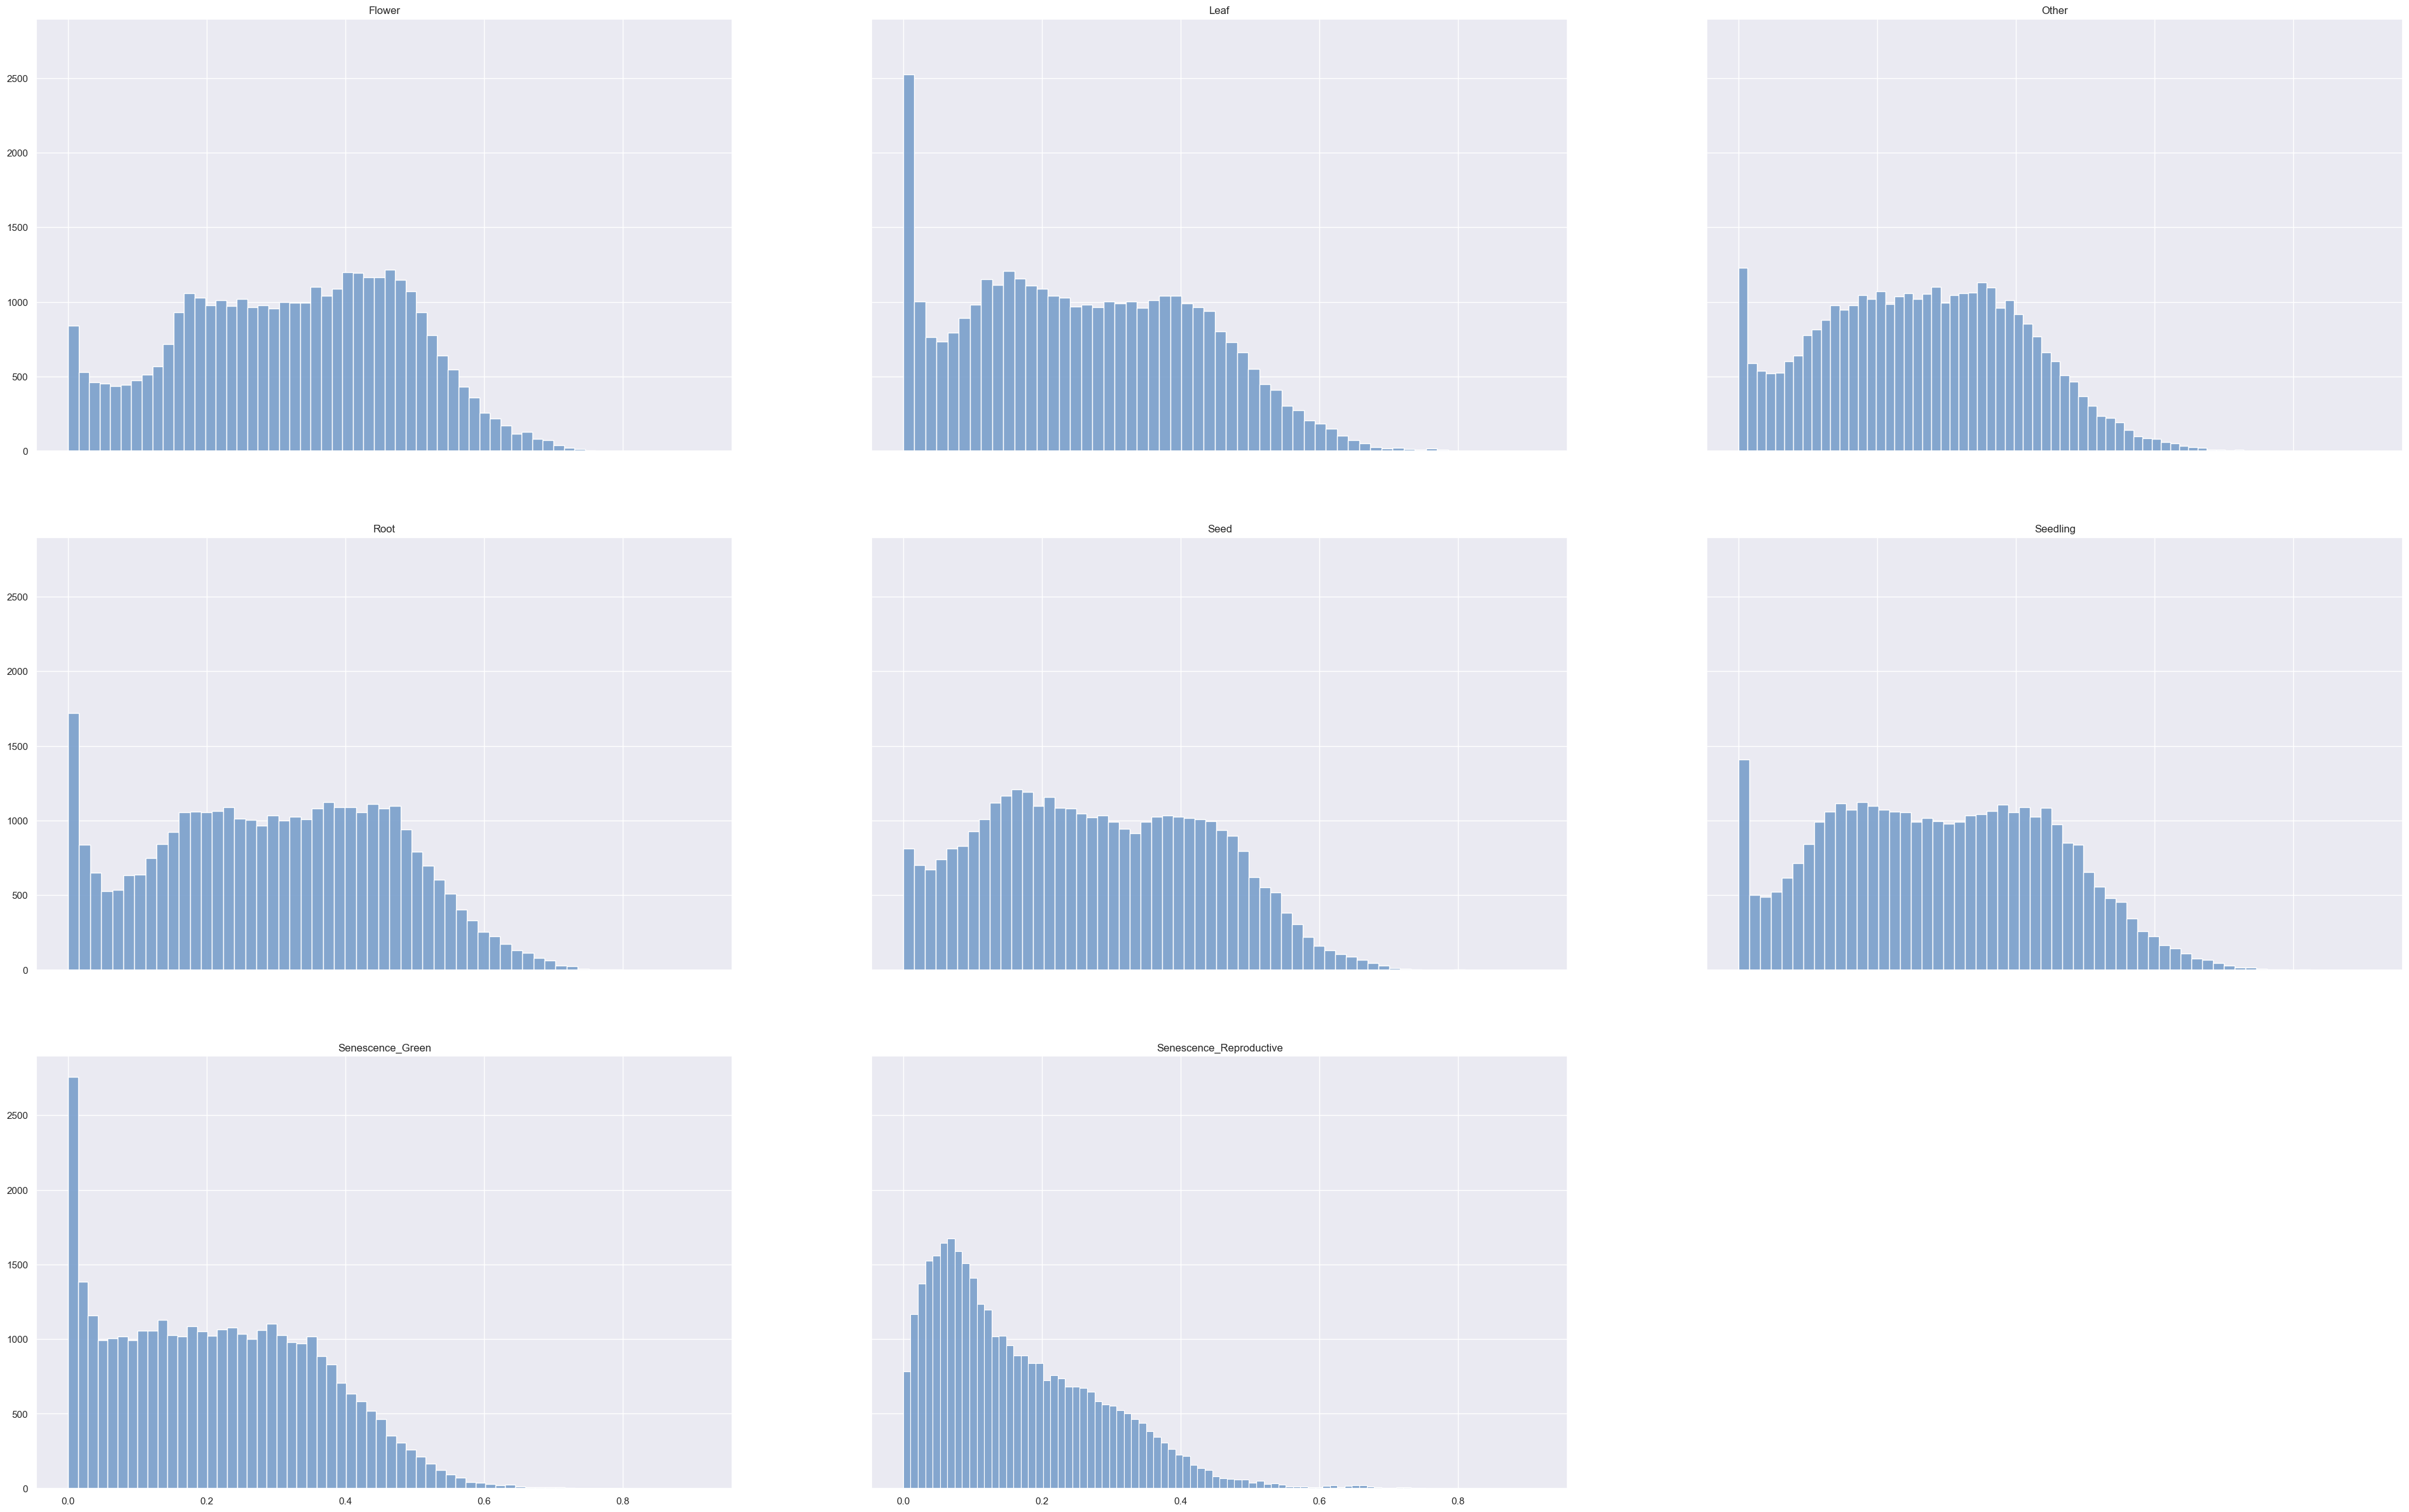

In [7]:
# Compute the regression distribution and display per tissue

distribution = data_target.distribution_group(
	data   = values,
	order  = order,
	select = 'mean',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-tissue-mean')
)

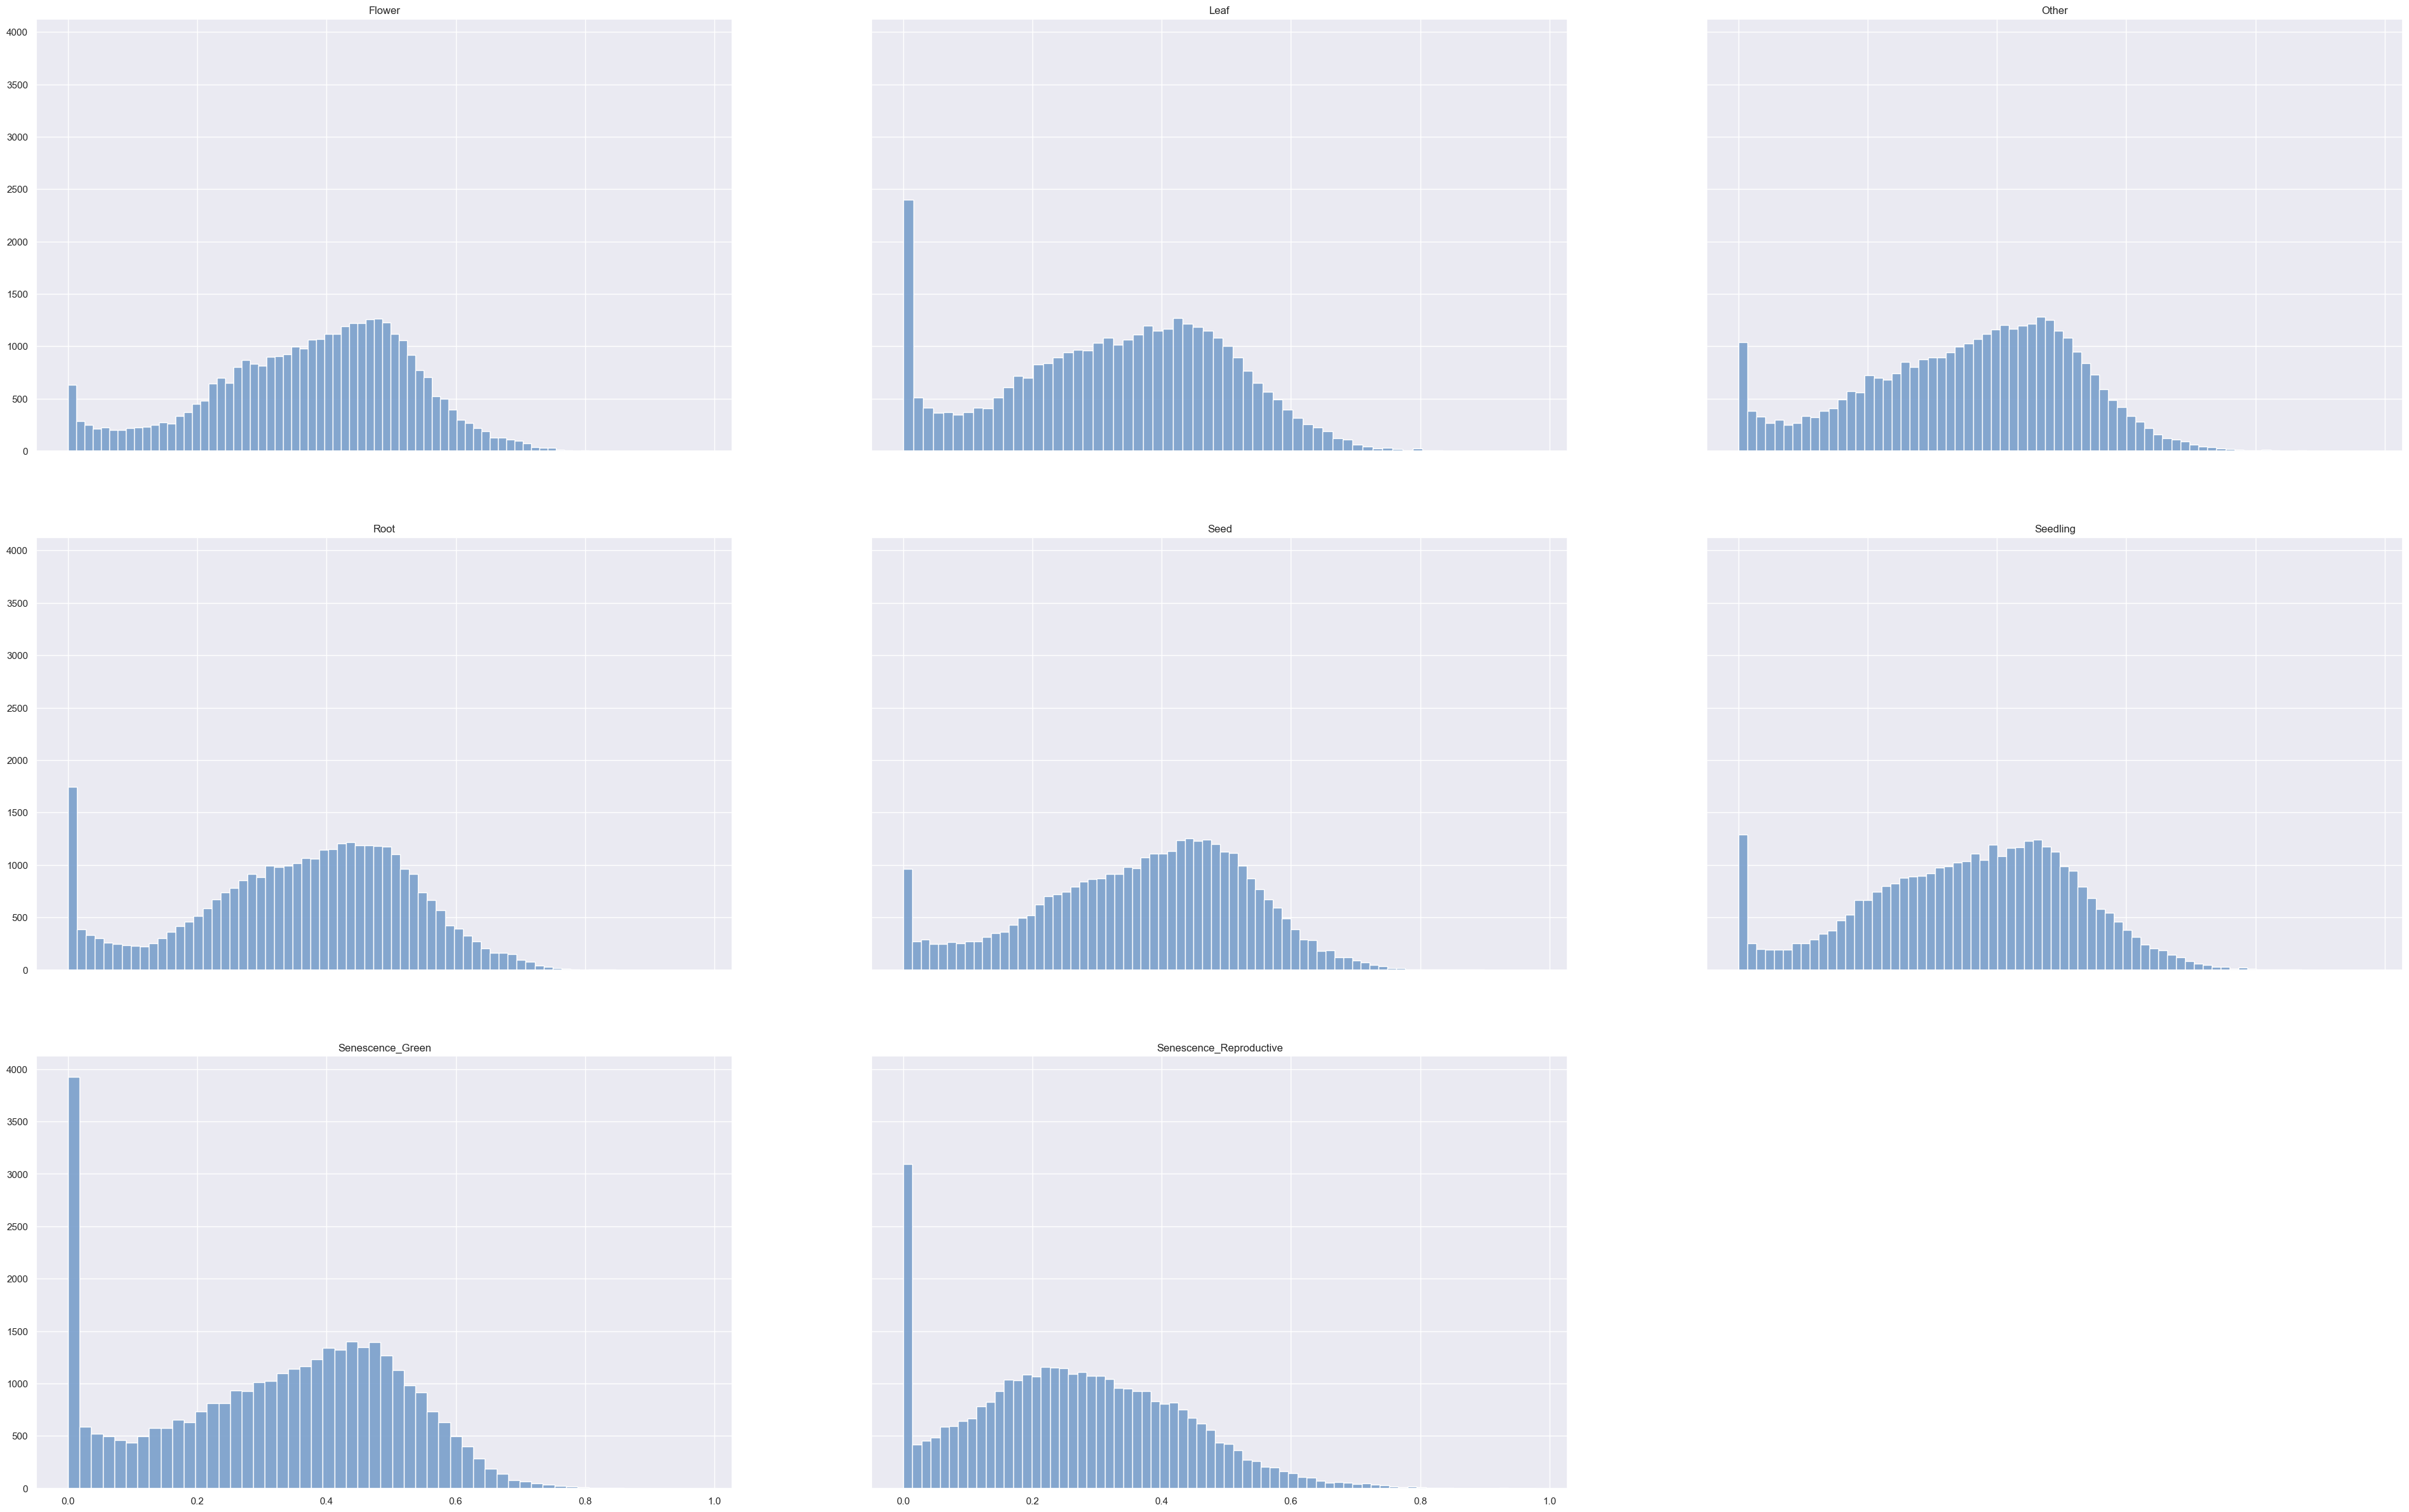

In [8]:
# Compute the regression distribution and display per tissue

distribution = data_target.distribution_group(
	data   = values,
	order  = order,
	select = 'p80',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-tissue-p80')
)

In [9]:
# Save the target gene tpm values

data_writer.write_json(
	data     = values,
	filename = os.path.join(OUT_DATA, 'target-values.json')
)

data_writer.write_json(
	data     = order,
	filename = os.path.join(OUT_DATA, 'target-order.json')
)

# 3. TPM Classification

In [10]:
# Extract the gene tpm classification per group (reuses tpm values from regression extraction)

labels, bounds = data_target.classify_tpm(
	data    = values,
	classes = 5
)

  0%|          | 0/34517 [00:00<?, ?it/s]

In [11]:
#

data_target.display_bounds_mapping(
	bounds     = bounds,
	group      = 'tissue-mean',
	min_value  = 0,
	max_value  = 4.700396577575031,
	box_lambda = 0.276804378358019
)

                            TPM |               log1p |            boxcox1p |                norm
--------------------------------+---------------------+---------------------+---------------------
level-0 :       0.0 -       0.5 |  0.00000 -  0.58687 |  0.00000 -  0.49257 |  0.00000 -  0.10479
level-1 :       0.5 -       1.5 |  0.58687 -  1.33383 |  0.49257 -  0.95517 |  0.10479 -  0.20321
level-2 :       1.5 -       4.1 |  1.33383 -  2.34951 |  0.95517 -  1.43563 |  0.20321 -  0.30543
level-3 :       4.1 -      12.5 |  2.34951 -  3.75901 |  1.43563 -  1.95108 |  0.30543 -  0.41509
level-4 :      12.5 -  60,789.1 |  3.75901 - 15.89155 |  1.95108 -  4.28778 |  0.41509 -  0.91222


In [12]:
# Display an example of the gene classification

gene = anndata.var.index.to_list()[0]

for index, (key, value) in enumerate(labels[gene].items()) :
	print(f'{key:17s} : [{len(value):2d}] ' + ' '.join('{:1d}'.format(x) for x in value))

tissue-max        : [ 8] 2 3 2 4 3 4 3 0
tissue-p80        : [ 8] 2 2 2 4 2 3 3 0
tissue-mean       : [ 8] 3 2 2 4 3 3 3 0
age-max           : [ 5] 3 3 1 3 4
age-p80           : [ 5] 3 3 2 3 3
age-mean          : [ 5] 3 3 3 2 3
group-max         : [19] 2 4 2 4 1 4 1 4 2 1 1 3 0 1 2 0 4 3 4
group-p80         : [19] 2 2 2 4 2 3 2 3 3 2 2 3 0 2 2 1 4 3 3
group-mean        : [19] 3 2 2 4 2 3 2 3 3 2 2 2 0 3 3 2 4 3 3
perturbation-max  : [ 8] 4 3 2 3 3 3 3 3
perturbation-p80  : [ 8] 3 3 3 3 2 2 3 3
perturbation-mean : [ 8] 3 3 4 3 2 2 2 3


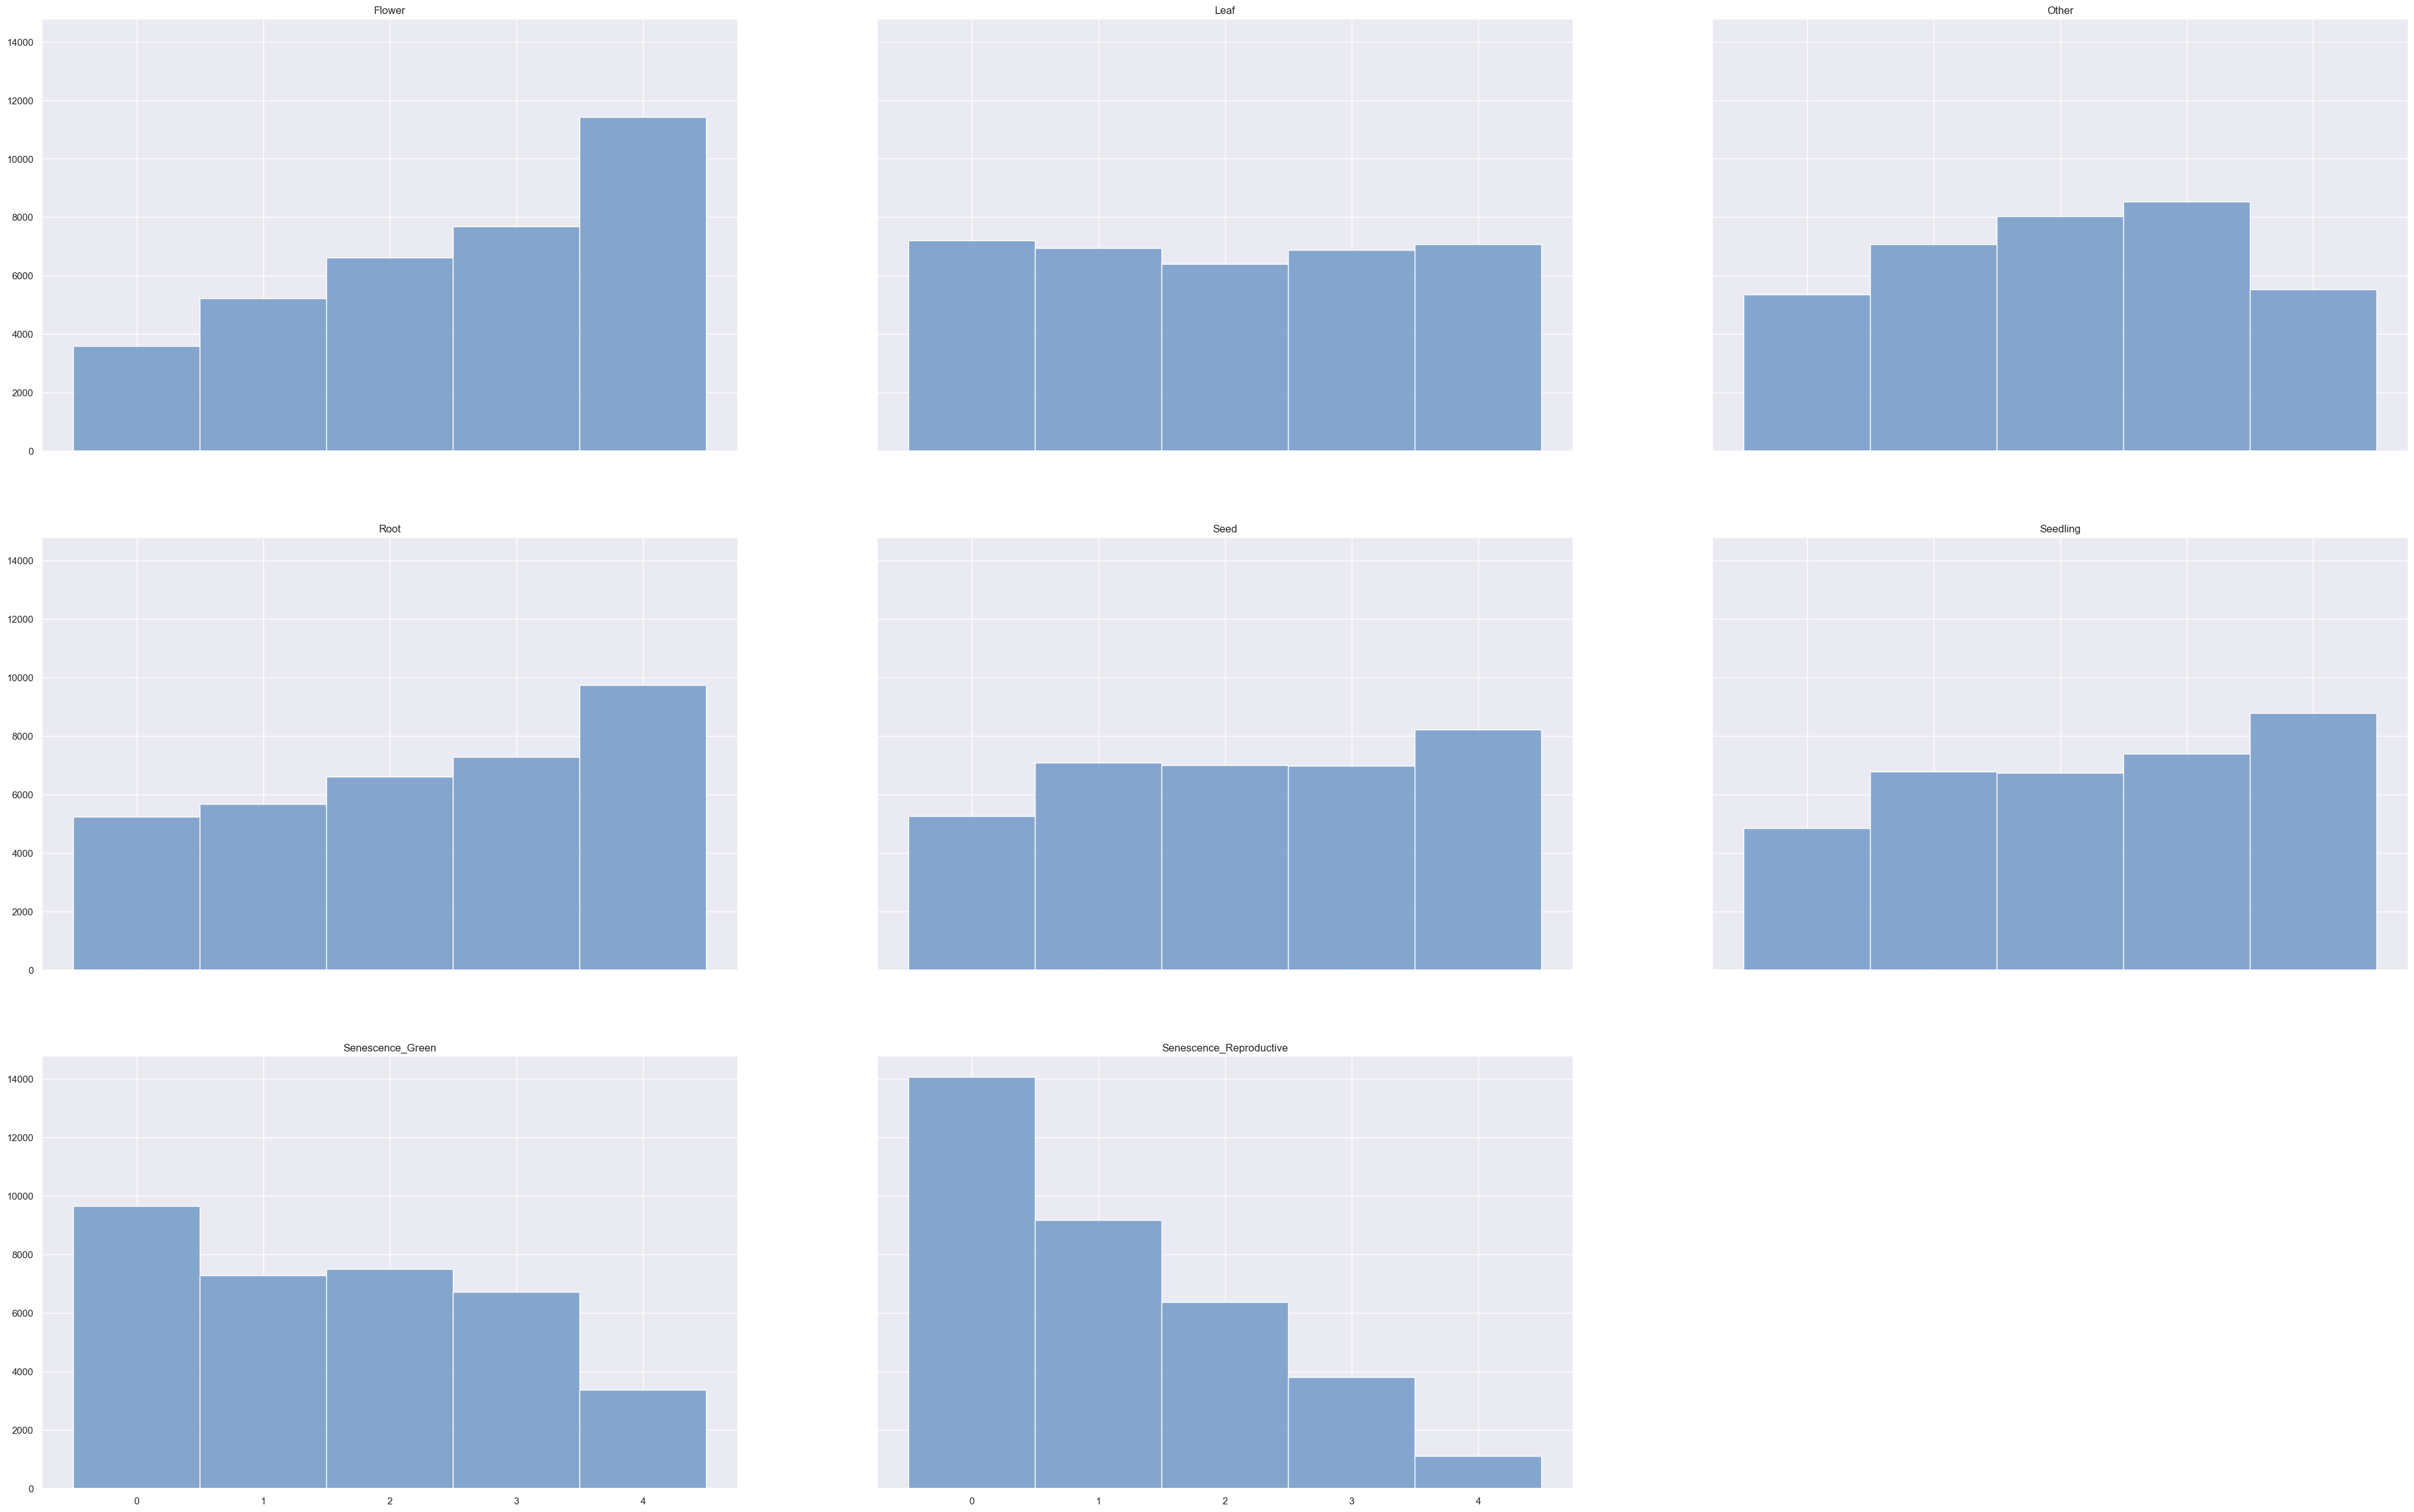

In [13]:
# Compute the classification distribution and display per tissue

distribution = data_target.distribution_group(
	data   = labels,
	order  = order,
	select = 'mean',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-class-tissue-mean')
)

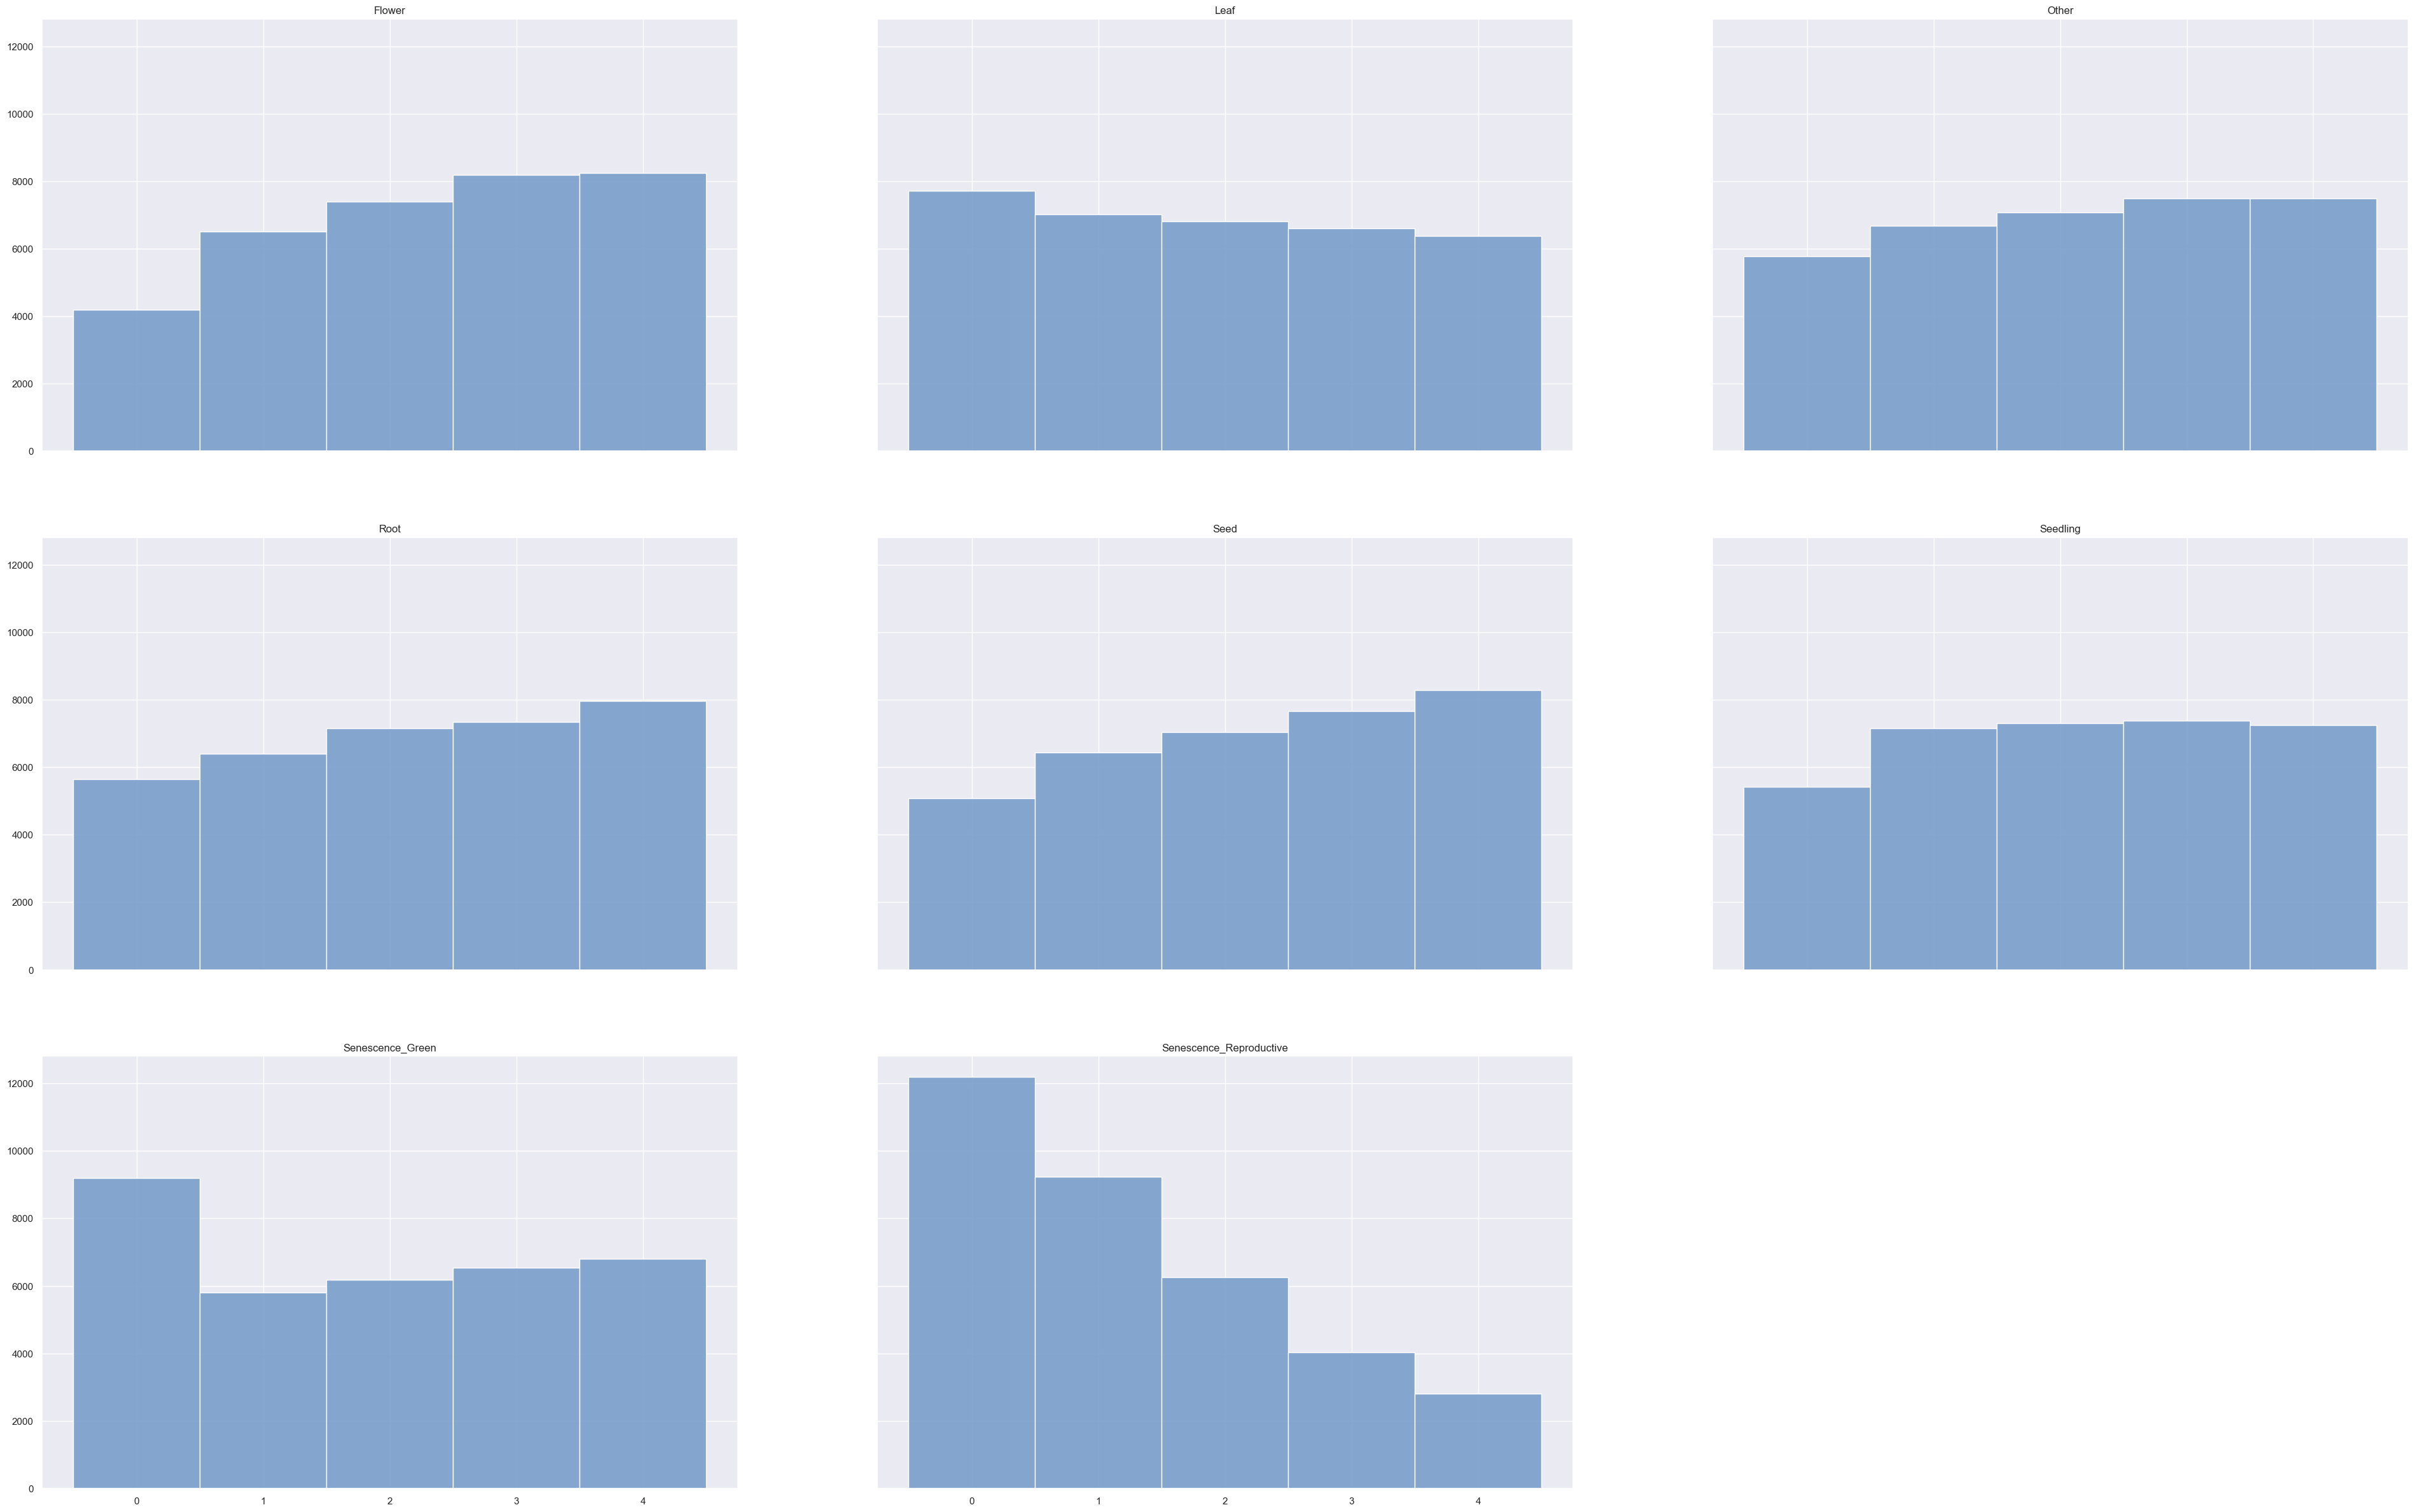

In [14]:
# Compute the classification distribution and display per tissue

distribution = data_target.distribution_group(
	data   = labels,
	order  = order,
	select = 'p80',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-class-tissue-p80')
)

In [15]:
# Save the target gene classification

data_writer.write_json(
	data     = labels,
	filename = os.path.join(OUT_DATA, 'target-labels.json')
)